# Exploratory data analaysis for FSNAU data

## Set export to True if you wish to export graphs and tables


In [1]:
export = True
seed = 1337


In [2]:
from itertools import product
import warnings
import pickle
from sklearn.cluster import KMeans
from matplotlib.cm import get_cmap
from matplotlib.patches import Patch
from os import listdir
import seaborn as sns
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from auxiliary_code.helper_functions import *
from auxiliary_code.Interpolation import Interpolation

%matplotlib inline

warnings.simplefilter('ignore')


# Loading data and removing outliers (0.1% filtering)


In [3]:
path = '../datasets/'

df_fsnau = pd.read_csv(path + 'fsnau_processed.csv', parse_dates=['date'])
set_index(df_fsnau)

df_pop = pd.read_csv(path + 'world_bank_processed.csv',
                     usecols=['date', 'area', 'pop'])
set_index(df_pop)

df_shape = get_shape_file('../geography/Somalia/Som_Admbnda_Adm2_UNDP.shp')
neighbors_dict = get_neighbour_dict(df_shape)

df_loc = pd.read_csv(path + 'locations_processed.csv').set_index('area')


In [4]:
df_sum = df_fsnau.describe().transpose().iloc[:, 1:]
isna_series = df_fsnau.isna().mean() * 100
isna_series.rename('% missing', inplace=True)
df_sum = df_sum.merge(isna_series, left_index=True, right_index=True)
df_sum


,mean,std,min,25%,50%,75%,max,% missing
Price of water,2.339987e+04,1.703064e+04,1000.0,12000.00,20000.0,30000.00,182500.0,47.109134
Sorghum prices,1.101207e+04,7.266013e+03,1500.0,5500.00,9000.0,14893.75,43750.0,43.841943
Maize prices,1.044334e+04,5.882476e+03,1600.0,6500.00,9000.0,13000.00,54000.0,46.767020
Red Rice prices,1.811292e+04,6.836669e+03,3625.0,14750.00,18000.0,22000.00,44000.0,27.540198
Local goat prices,1.022151e+06,4.751344e+05,60500.0,730000.00,960000.0,1280000.00,2894000.0,27.805337
Wage labor,9.239817e+04,4.816674e+04,11250.0,59937.50,82500.0,120000.00,1000000.0,28.575094
TOT (goat to cereals),1.064372e+02,7.996449e+01,0.0,56.00,79.0,130.00,1124.0,33.587068
TOT (wage to cereals),9.368503e+00,5.792829e+00,0.0,5.00,8.0,12.00,152.0,34.339719
Cost of Minimum Basket (CMB),2.832127e+06,1.317242e+06,250500.0,1991446.75,2511812.5,3495359.50,8538781.0,52.668491
New Admissions (GAM),7.765289e+02,1.857295e+03,0.0,100.00,296.0,745.00,35359.0,62.547041


# Interpolation


In [5]:
price_columns = ['Price of water', 'Sorghum prices', 'Maize prices', 'Red Rice prices'] + ['Local goat prices', 'Wage labor',
                                                                                           'TOT (goat to cereals)', 'TOT (wage to cereals)',
                                                                                           'Cost of Minimum Basket (CMB)']

interpolation = Interpolation(df_fsnau, price_columns, neighbors_dict)

df_fsnau_int = interpolation.interpolate_spatially()
na_means = interpolation.get_na_means()


# Figures


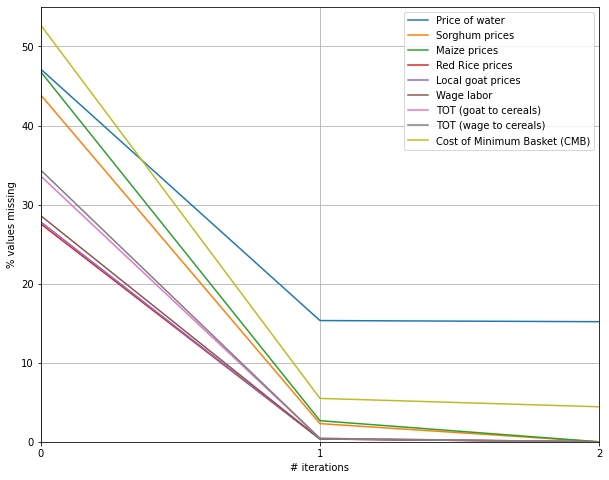

In [6]:
fig, ax = plt.subplots(figsize=(10, 8))

ax.plot(np.array(na_means)*100, label=price_columns)
ax.legend()
ax.set_xlabel('# iterations')
ax.set_ylabel('% values missing')
ax.grid()
ax.set_xlim(0, len(na_means) - 1)
ax.set_xticks(range(len(na_means)))
ax.set_ylim(0, 55)

if export:
    fig.savefig('../Figures/interpolation_convergence.png', dpi=300)


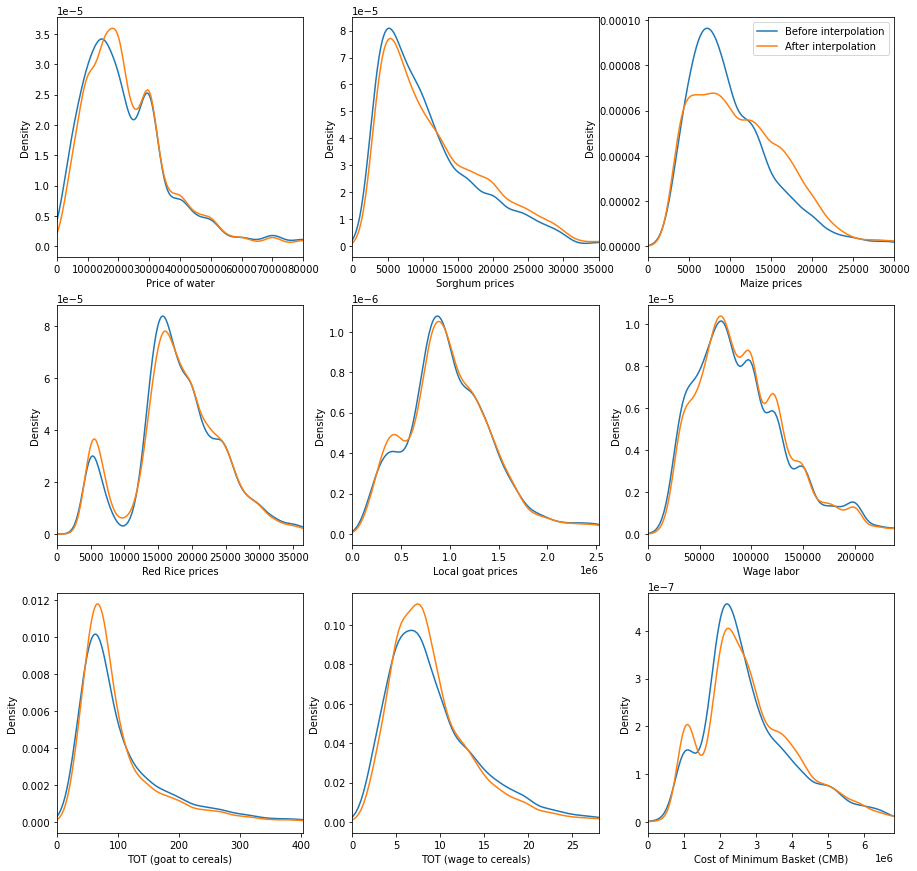

In [7]:
fig, axs = plt.subplots(figsize=(15, 15), nrows=3, ncols=3)

for i, ax in enumerate(axs.flatten()):
    df_fsnau[price_columns[i]].plot(kind='kde', ax=ax)
    df_fsnau_int[price_columns[i]].plot(kind='kde', ax=ax)
    ax.set_xlabel(price_columns[i])
    ax.set_xlim(0, df_fsnau[price_columns[i]].quantile(0.99))
    if i == 2:
        ax.legend(['Before interpolation', 'After interpolation'])

if export:
    fig.savefig('../Figures/interpolation_kde.png', dpi=300)


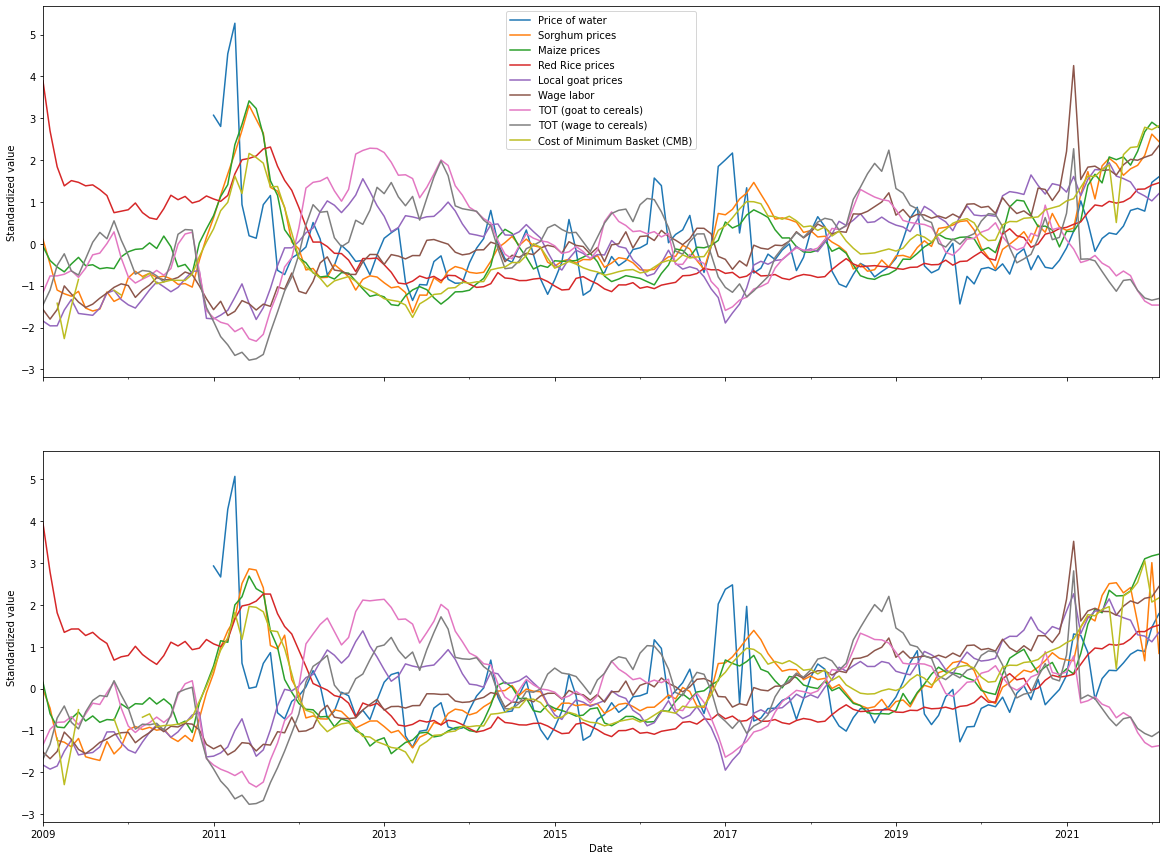

In [8]:
fig, ax = plt.subplots(figsize=(20, 15), nrows=2, sharex=True, sharey=True)

ts = df_fsnau.groupby('date')[price_columns].mean()
((ts - ts.mean())/ts.std()).plot(ax=ax[0])
ts = df_fsnau_int.groupby('date')[price_columns].mean()
((ts - ts.mean())/ts.std()).plot(ax=ax[1])
ax[0].set_ylabel('Standardized value')
ax[1].set_ylabel('Standardized value')
ax[0].set_xlabel('')
ax[1].set_xlabel('Date')
ax[1].get_legend().remove()

if export:
    plt.savefig('../Figures/prices_mean_area_interpolated_temporal.png',
                dpi=300, bbox_inches='tight')


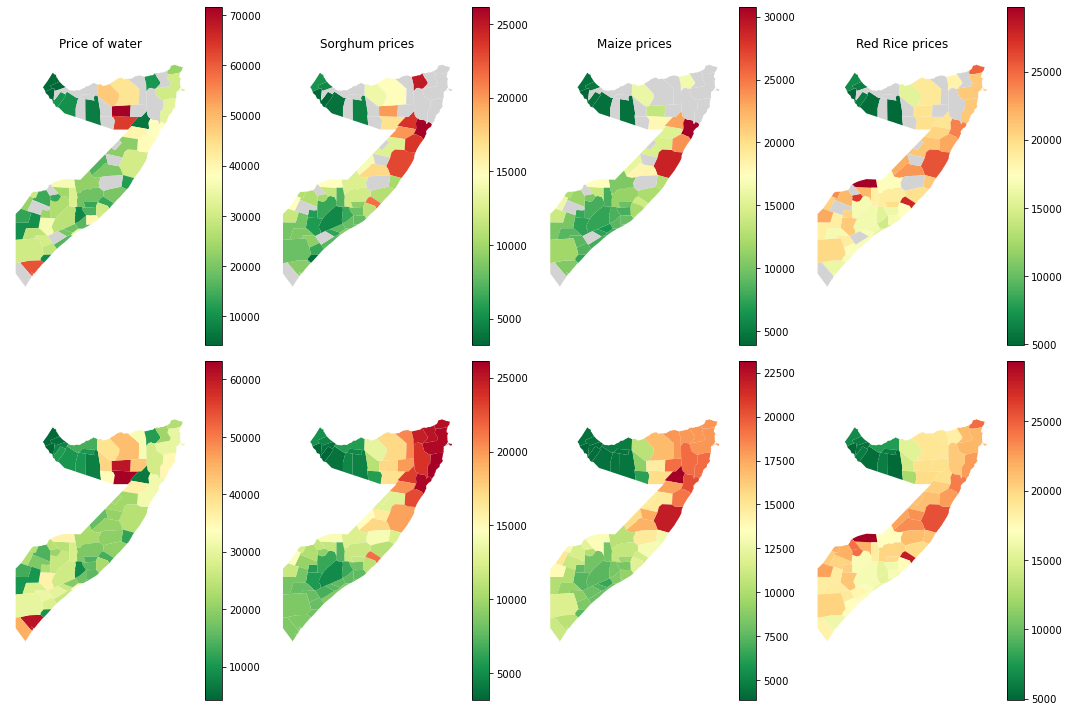

In [9]:
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(15, 10))

missing_kwds = {"color": "lightgrey", "label": "Missing values"}
cols = ['Price of water', 'Sorghum prices', 'Maize prices', 'Red Rice prices']

for i, df in enumerate([df_fsnau, df_fsnau_int]):
    df_mean_prices = df.groupby('area')[cols].mean()
    df_plot = df_shape.merge(
        df_mean_prices, left_index=True, right_index=True)
    for j, col in enumerate(cols):
        df_plot.plot(column=col, cmap='RdYlGn_r', legend=True,
                     ax=axs[i, j], missing_kwds=missing_kwds)
        axs[i, j].axis('off')
        axs[0, j].set_title(col)

plt.tight_layout()

if export:
    plt.savefig('../Figures/prices_mean_area_interpolated_spatial.png',
                dpi=300, bbox_inches='tight')
